In [ ]:
from datetime import datetime
import IPython
import os
import pickle
import PIL
import pprint
import random

import datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchinfo
import torchvision
from tqdm.notebook import tqdm
random.seed(3407)
np.random.seed(3407)
torch.manual_seed(3407)
torch.cuda.manual_seed(3407)
torch.backends.cudnn.benchmark = True  # ループ内で順伝播や逆伝播が同じ計算手法ならば処理を高速化させる

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**データ収集(今回はデータとして、HuggingFaceにあるアニメ顔画像を使う)**

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/63565 [00:00<?, ? examples/s]

Dataset({
    features: ['image'],
    num_rows: 63565
})
{'image': Image(decode=True, id=None)}
63565
63565
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=57x57 at 0x7850E40C0AF0>


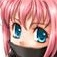

(57, 57, 3)


In [ ]:
# HuggingFaceにあるアニメ顔画像DatasetDictをロード
hugging_face_dataset_dict = datasets.load_dataset("DrishtiSharma/Anime-Face-Dataset", trust_remote_code=True)
# ロードしたDatasetDictからDataset(DatasetDictにあるtrainのDatasetのみ)を取得
ds = hugging_face_dataset_dict["train"]
# Datasetを確認
print(ds)
# Dataset内のデータのタイプを確認
print(ds.features)
# 一部のデータは白黒画像などで3階数テンソルではないので、そのデータを弾く
RGB_row_list_1 = [id_1 for id_1 in range(ds.num_rows) if len(np.array(ds[id_1]["image"]).shape) == 3]  # 3階数テンソルである画像データの行番号を取得
ds = ds.select(indices=RGB_row_list_1)  # その行番号のデータだけを取得
# 一部のデータは3チャンネルでなく、4チャンネル(αチャンネルを持つ)なので、そのデータを弾く
RGB_row_list_2 = [id_2 for id_2 in range(ds.num_rows) if np.array(ds[id_2]["image"]).shape[2] == 3]  # チャンネル数が3である画像データの行番号を取得
ds = ds.select(indices=RGB_row_list_2)  # その行番号のデータだけを取得
# *****の画像(ラベルが1)だけの形にする
# *****_row_list = [id for id in range(ds.num_rows) if ds[id]["labels"] == 1]  # labelsの値が1であるデータの行番号を取得
# ds = ds.select(indices=*****_row_list)  # その行番号のデータだけを取得
# データを確認
print(ds.num_rows)
print(len(ds))  # 後続でのDataset処理を踏まえて、lenでもデータ数を取得出来る事を確認
print(ds[100]["image"])
IPython.display.display(ds[100]["image"])
print(np.array(ds[100]["image"]).shape)

In [ ]:
fig = plt.figure(figsize=(10, 12))
for i in range(30):
    fig.add_subplot(6, 5, i+1)
    plt.imshow(X=np.array(ds[i]["image"]))
    plt.axis("off")
plt.show()

**訓練データ(正解ラベル無しデータ)を準備**

3
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=62x62 at 0x7850DE312E90>


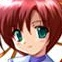

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=79x79 at 0x7850DE3131F0>


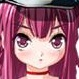

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x51 at 0x7850DE313490>


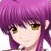

In [ ]:
# 生成タスクなので、validationデータでの評価を行わないため、validationデータは作らない
num_data = ds.num_rows
# 全てのデータを使おうとするとCPUメモリが溢れるので、データの0.05%だけを使う
# train_image_ds = ds[:int(num_data*0.0005)]["image"]
train_image_ds = ds[1:4]["image"]
# train_label_ds = ds[:int(num_data*0.03)]["labels"]  # 正解ラベルではなく、後続処理の時に何のデータであるのかの目印として用いる
print(len(train_image_ds))
print(train_image_ds[0])
IPython.display.display(train_image_ds[0])
print(train_image_ds[1])
IPython.display.display(train_image_ds[1])
print(train_image_ds[2])
IPython.display.display(train_image_ds[2])

**前処理(データ拡張含む)の準備**

In [ ]:
# データ拡張(Data Augmentation)を定義
image_transform_method = torchvision.transforms.Compose([torchvision.transforms.Resize(size=(96, 96)),
                                                         torchvision.transforms.RandomHorizontalFlip(p=0.5),
                                                         torchvision.transforms.RandomRotation(degrees=(-10, 10))])

In [ ]:
# 正規化とテンソル化を定義
def normalize_and_tensorize(PIL_image):
    array_image = np.array(PIL_image).transpose(2, 0, 1)  # PILをnumpyにして、形状を(チャンネル, 縦, 横)
    normalize_array_image = array_image / 255  # 255で割って正規化
    normalize_tensor_image = torch.FloatTensor(normalize_array_image)  # arrayをtensorにする
    return normalize_tensor_image

In [ ]:
# Datasetクラスを定義
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, image_datas, data_augmentation, tensorize):
    # def __init__(self, image_datas, label_datas, data_augmentation, tensorize):
        super().__init__()
        self.image_datas = image_datas
        # self.label_datas = label_datas
        self.data_augmentation = data_augmentation
        self.tensorize = tensorize

    def __len__(self):
        return len(self.image_datas)

    def __getitem__(self, idx):
        image = self.image_datas[idx]
        augmentation_image = self.data_augmentation(image)
        augmentation_tensor_image = self.tensorize(PIL_image=augmentation_image)
        # label = self.label_datas[idx]
        return augmentation_tensor_image
        # return augmentation_tensor_image, label

**前処理**

In [ ]:
train_dataset = MyDataset(image_datas=train_image_ds,
                          # label_datas=train_label_ds,
                          data_augmentation=image_transform_method,
                          tensorize=normalize_and_tensorize)

In [ ]:
train_dataset_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                       batch_size=50,
                                                       shuffle=True)

**VAE(Variational Auto Encoder)モデルを作成**

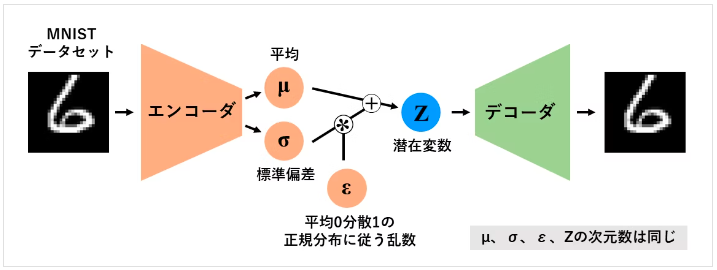

Encoder側

In [ ]:
class MyVAEEncoderConvLayer(torch.nn.Module):
    def __init__(self, input_n, output_n):
        super().__init__()
        self.layer_1 = torch.nn.Conv2d(in_channels=input_n,  # チャンネル数を指定の値にして、解像度を半分にする
                                       out_channels=output_n,
                                       kernel_size=2,
                                       stride=2,
                                       padding=0)
        self.layer_2 = torch.nn.BatchNorm2d(num_features=output_n)
        # self.layer_3 = torch.nn.AvgPool2d(kernel_size=2,  # 解像度を半分にする
        #                                   stride=2,
        #                                   padding=0)

    def forward(self, in_data_layer):
        out_data_layer_1 = self.layer_1(in_data_layer)
        out_data_layer_2 = torch.nn.functional.leaky_relu(input=self.layer_2(out_data_layer_1),  # BatchNormの後にLeakyReLU
                                                          negative_slope=0.01)
        return out_data_layer_2
        # out_data_layer_3 = self.layer_3(out_data_layer_2)
        # return out_data_layer_3

In [ ]:
class MyVAEEncoder(torch.nn.Module):
    def __init__(self, in_num, out_num, hw_size):
        super().__init__()
        self.layer_1 = MyVAEEncoderConvLayer(input_n=in_num,
                                             output_n=32)
        self.layer_2 = MyVAEEncoderConvLayer(input_n=32,
                                             output_n=64)
        self.layer_3 = MyVAEEncoderConvLayer(input_n=64,
                                             output_n=128)
        self.layer_4 = MyVAEEncoderConvLayer(input_n=128,
                                             output_n=256)
        self.layer_5 = MyVAEEncoderConvLayer(input_n=256,
                                             output_n=512)
        self.layer_6_mu = torch.nn.Linear(in_features=512*int(hw_size/(2**5))*int(hw_size/(2**5)),
                                          out_features=out_num)  # out_num(z_dim)は256
        self.layer_6_sigma = torch.nn.Linear(in_features=512*int(hw_size/(2**5))*int(hw_size/(2**5)),
                                             out_features=out_num)  # out_num(z_dim)は256

    def forward(self, in_data_encoder):
        # print("en_in", in_data_encoder.shape)  # (30, 3, 96, 96)
        out_data_layer_1 = self.layer_1(in_data_encoder)
        # print("en_1", out_data_layer_1.shape)  # (30, 32, 48, 48)
        out_data_layer_2 = self.layer_2(out_data_layer_1)
        # print("en_2", out_data_layer_2.shape)  # (30, 64, 24, 24)
        out_data_layer_3 = self.layer_3(out_data_layer_2)
        # print("en_3", out_data_layer_3.shape)  # (30, 128, 12, 12)
        out_data_layer_4 = self.layer_4(out_data_layer_3)
        # print("en_4", out_data_layer_4.shape)  # (30, 256, 6, 6)
        out_data_layer_5 = self.layer_5(out_data_layer_4)
        # print("en_5", out_data_layer_5.shape)  # (30, 512, 3, 3)
        c = out_data_layer_5.shape[1]
        h = out_data_layer_5.shape[2]
        w = out_data_layer_5.shape[3]
        in_data_layer_6 = out_data_layer_5.view(-1, c*h*w)
        # print("en_in5", in_data_layer_5.shape)  # (30, 4608)
        mu = self.layer_6_mu(in_data_layer_6)  # 潜在変数のネタ1(μ)
        # print("mu", mu.shape)  # (30, 256)
        sigma = self.layer_6_sigma(in_data_layer_6)  # 潜在変数のネタ2(σ)
        # print("sigma", sigma.shape)  # (30, 256)
        epsilon = torch.randn_like(mu)  # 潜在変数のネタ3(ε)で、正規分布の乱数
        # print("epsilon", epsilon.shape)  # (30, 256)
        z = mu + torch.exp(sigma/2) * epsilon  # 再パラメータ化トリックで算出した潜在変数(z)
        # print("z", z.shape)  # (30, 256)
        return z, mu, sigma

Decoder側

In [ ]:
class MyVAEDecoderUpConvLayer(torch.nn.Module):
    def __init__(self, input_n, output_n):
        super().__init__()
        self.layer_1 = torch.nn.ConvTranspose2d(in_channels=input_n,  # チャンネル数を指定の値にして、解像度を2倍にする
                                                out_channels=output_n,
                                                kernel_size=3,
                                                stride=2,
                                                padding=1,
                                                output_padding=1)
        self.layer_2 = torch.nn.BatchNorm2d(num_features=output_n)

    def forward(self, in_data_layer):
        out_data_layer_1 = self.layer_1(in_data_layer)
        out_data_layer_2 = torch.nn.functional.leaky_relu(input=self.layer_2(out_data_layer_1),  # BatchNormの後にLeakyReLU
                                                          negative_slope=0.01)
        return out_data_layer_2

In [ ]:
class MyVAEDecoder(torch.nn.Module):
    def __init__(self, in_num, out_num, hw_size):
        super().__init__()
        self.hw_size = int(hw_size / 2**5)  # 96/2^5=3
        self.layer_1 = torch.nn.Linear(in_features=in_num,  # in_num(z_dim)は256
                                       out_features=512*self.hw_size*self.hw_size)
        self.layer_2 = MyVAEDecoderUpConvLayer(input_n=512,
                                               output_n=256)
        self.layer_3 = MyVAEDecoderUpConvLayer(input_n=256,
                                               output_n=128)
        self.layer_4 = MyVAEDecoderUpConvLayer(input_n=128,
                                               output_n=64)
        self.layer_5 = MyVAEDecoderUpConvLayer(input_n=64,
                                               output_n=32)
        self.layer_6 = MyVAEDecoderUpConvLayer(input_n=32,
                                               output_n=3)
        self.layer_7 = torch.nn.Conv2d(in_channels=3,
                                       out_channels=out_num,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)

    def forward(self, in_data_decoder):
        # print("de_in", in_data_decoder.shape)  # (30, 256)
        out_data_layer_1 = torch.nn.functional.leaky_relu(input=self.layer_1(in_data_decoder),  # 全結合層の後にLeakyReLU
                                                          negative_slope=0.01)
        # print("de_1", out_data_layer_1.shape)  # (30, 4608)
        in_data_layer_2 = out_data_layer_1.view(-1, 512, self.hw_size, self.hw_size)
        # print("de_in2", in_data_layer_2.shape)  # (30, 512, 3, 3)
        out_data_layer_2 = self.layer_2(in_data_layer_2)
        # print("de_2", out_data_layer_2.shape)  # (30, 256, 6, 6)
        out_data_layer_3 = self.layer_3(out_data_layer_2)
        # print("de_3", out_data_layer_3.shape)  # (30, 128, 12, 12)
        out_data_layer_4 = self.layer_4(out_data_layer_3)
        # print("de_4", out_data_layer_4.shape)  # (30, 64, 24, 24)
        out_data_layer_5 = self.layer_5(out_data_layer_4)
        # print("de_5", out_data_layer_5.shape)  # (30, 32, 48, 48)
        out_data_layer_6 = self.layer_6(out_data_layer_5)
        # print("de_6", out_data_layer_6.shape)  # (30, 3, 96, 96)
        out_data_layer_7 = self.layer_7(out_data_layer_6)
        # print("de_7", out_data_layer_7.shape)  # (30, 3, 96, 96)
        return out_data_layer_7

VAEモデル

In [ ]:
class MyVAE(torch.nn.Module):
    def __init__(self, in_dim, z_dim, out_dim, size):
        super().__init__()
        self.layer_encoder = MyVAEEncoder(in_num=in_dim,
                                          out_num=z_dim,
                                          hw_size=size)
        self.layer_decoder = MyVAEDecoder(in_num=z_dim,
                                          out_num=out_dim,
                                          hw_size=size)

    def forward(self, in_data):
        z, mu, sigma = self.layer_encoder(in_data)
        out_data = self.layer_decoder(z)
        return out_data, z, mu, sigma

    def generate_image(self, in_tensor_data):
        out_data = self.layer_decoder(in_tensor_data)
        # print(out_data.shape)
        out_data_sigmoid = torch.sigmoid(out_data)  # テンソルの要素の値を0～1にするため
        # print(out_data_sigmoid.shape)
        return out_data_sigmoid

**モデル、損失関数、最適化アルゴリズム**

VAEモデル時の損失関数は下記の式

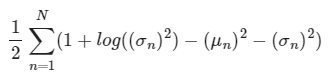

In [ ]:
nn_model = MyVAE(in_dim=3,
                 z_dim=256,
                 out_dim=3,
                 size=96).to(device)  # GPUへ
loss_BCE = torch.nn.BCEWithLogitsLoss(reduction="sum")
optimizer = torch.optim.Adam(params=nn_model.parameters(),
                             lr=0.001)

In [ ]:
torchinfo.summary(model=nn_model,
                  input_size=(30, 3, 96, 96),
                  depth=5)

**学習**

In [ ]:
FOLDER_NAME = "./VAE"

In [ ]:
if os.path.isfile(path="{a}/epoch_train_loss_total_list.pkl".format(a=FOLDER_NAME)):
    with open(file="{a}/epoch_train_loss_total_list.pkl".format(a=FOLDER_NAME), mode="rb") as f:
        epoch_train_loss_total_list = pickle.load(file=f)
else:
    epoch_train_loss_total_list = []
if os.path.isfile(path="{a}/epoch_z_vector_dict.pkl".format(a=FOLDER_NAME)):
    with open(file="{a}/epoch_z_vector_dict.pkl".format(a=FOLDER_NAME), mode="rb") as f:
        epoch_z_vector_dict = pickle.load(file=f)
else:
    epoch_z_vector_dict = {"face": []}
if os.path.isfile(path="{a}/FineTuning_VAE.model".format(a=FOLDER_NAME)):
    nn_model.load_state_dict(state_dict=torch.load(f="{a}/FineTuning_VAE.model".format(a=FOLDER_NAME)))
# エポック毎
for epoch in tqdm(range(100)):
    # 学習
    epoch_train_loss_total = 0
    z_vector_face_list = []
    nn_model.train()
    for train_input_tensor_minibatch in train_dataset_dataloader:
    # for train_input_tensor_minibatch, train_label_tensor_minibatch in train_dataset_dataloader:
        train_input_tensor_minibatch = train_input_tensor_minibatch.to(device)  # GPUへ
        # train_label_tensor_minibatch = train_label_tensor_minibatch.to(device)  # GPUへ
        output, z, mu, sigma = nn_model(in_data=train_input_tensor_minibatch)
        loss_1 = loss_BCE(output, train_input_tensor_minibatch)  # 損失関数でのBinaryCrossEntropy
        loss_2 = -0.5 * torch.sum(1 + sigma - mu**2 - sigma.exp())  # 損失関数での正則化項
        loss = loss_1 + loss_2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss_total = epoch_train_loss_total + loss.item()
        z_vector_face_list.append(z.detach().cpu().numpy())
        # for i in range(train_label_tensor_minibatch.shape[0]):
            # if int(train_label_tensor_minibatch[i]) == 1:  # 入力データのラベルが1ならば、その入力データは*****なので、
                # z_vector_*****_list.append(z[i].detach().cpu().numpy().reshape(1, -1))  # *****の潜在変数として分ける
    epoch_train_loss_total_list.append(epoch_train_loss_total)
    with open(file="{a}/epoch_train_loss_total_list.pkl".format(a=FOLDER_NAME), mode="wb") as f:
        pickle.dump(obj=epoch_train_loss_total_list,
                    file=f)
    z_vector_face = np.concatenate(z_vector_face_list,  # 潜在変数のベクトルを1つにコンカチして、
                                   axis=0)
    epoch_z_vector_dict["face"].append(z_vector_face)  # 辞書型のfaceをキーとした値のリストにepoch毎に追記する
    with open(file="{a}/epoch_z_vector_dict.pkl".format(a=FOLDER_NAME), mode="wb") as f:
        pickle.dump(obj=epoch_z_vector_dict,
                    file=f)
    torch.save(obj=nn_model.state_dict(),
               f="{a}/FineTuning_VAE.model".format(a=FOLDER_NAME))

**損失値の推移をグラフ化**

In [ ]:
with open(file="{a}/epoch_train_loss_total_list.pkl".format(a=FOLDER_NAME), mode="rb") as f:
    epoch_train_loss_total_list = pickle.load(file=f)
with open(file="{a}/epoch_z_vector_dict.pkl".format(a=FOLDER_NAME), mode="rb") as f:
    epoch_z_vector_dict = pickle.load(file=f)

In [ ]:
colors = list(matplotlib.colors.CSS4_COLORS.values())
random.shuffle(colors)

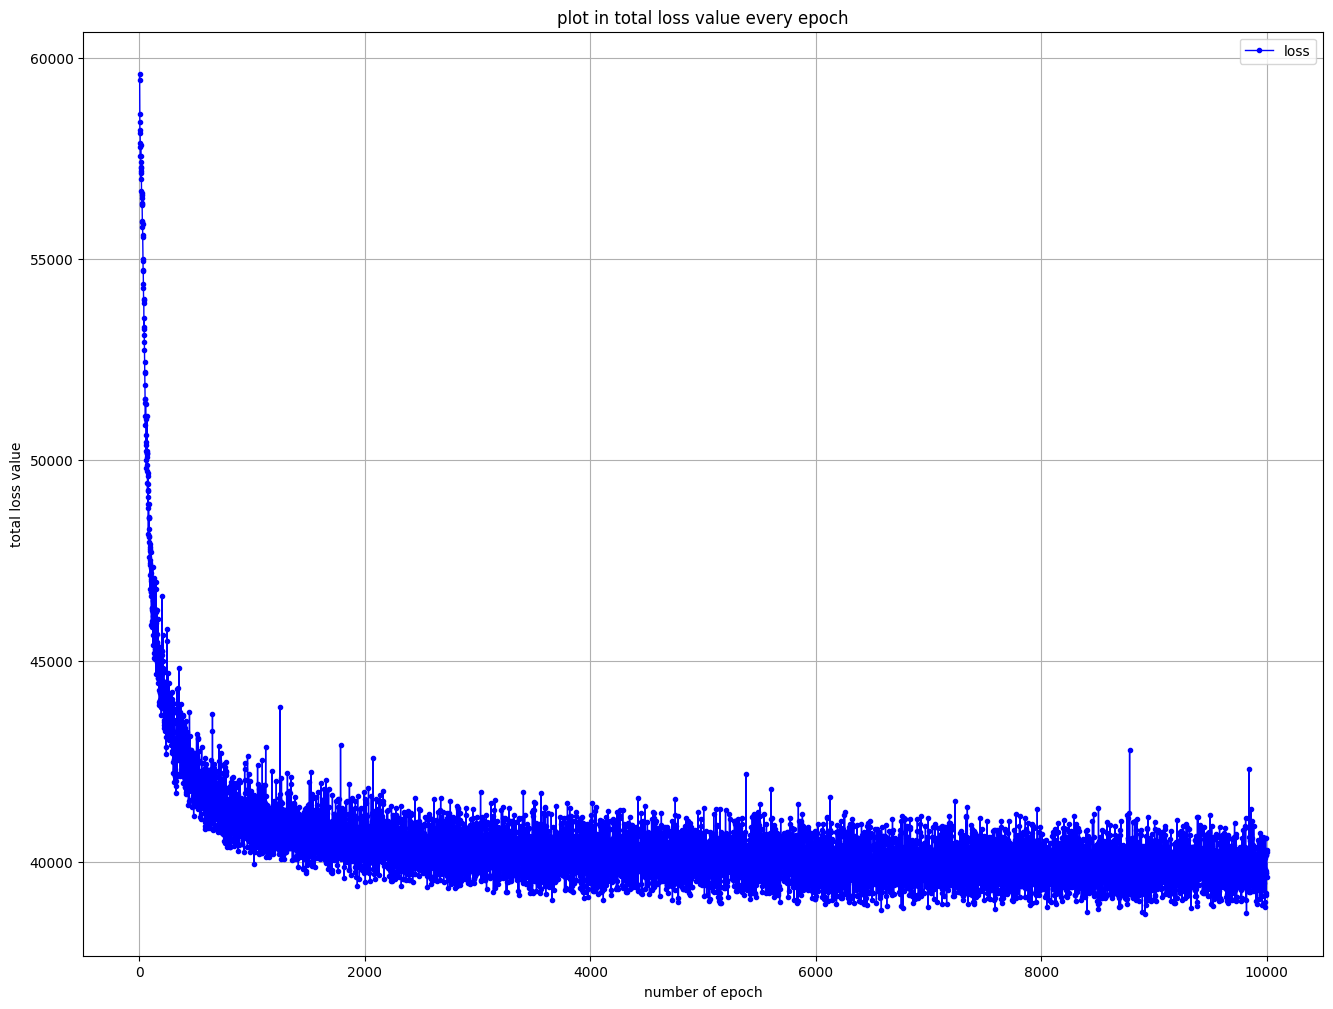

In [ ]:
# fig, (axes1, axes2) = plt.subplots(nrows=2,
#                                    ncols=1,
#                                    figsize=(16, 20))
fig, (axes1) = plt.subplots(nrows=1,
                            ncols=1,
                            figsize=(16, 12))
# 損失値の推移
x_datas = np.arange(1, len(epoch_train_loss_total_list)+1, 1)
y_datas_list = [epoch_train_loss_total_list]
labels = ["loss"]
for i, y_datas in enumerate(y_datas_list):
    axes1.plot(x_datas,
               y_datas,
               label=labels[i],
               c=colors[i],
               marker="o",
               markersize=3,
               linestyle="solid",
               linewidth=1)
    # for j in range(len(y_datas)):
        # axes1.annotate(text=round(y_datas[j], 3),
        #                xy=(x_datas[j], y_datas[j]))
axes1.legend()
axes1.set_title("plot in total loss value every epoch")
axes1.set_xlabel("number of epoch")
axes1.set_ylabel("total loss value")
# axes1.set_xticks(ticks=x_datas)
axes1.grid(True)
# 最新epoch学習後の潜在変数(潜在変数を2次元とした時のグラフ化)
# for i, (k, v) in enumerate(epoch_z_vector_dict.items()):
#     newest_v = v[-1]
#     x_values = newest_v[:, 0]
#     y_values = newest_v[:, 1]
#     axes2.scatter(x=x_values,
#                   y=y_values,
#                   c=colors[i],
#                   label=k,
#                   marker=".",
#                   s=70)
# axes2.legend()
# axes2.set_title("plot in z vector every label")
# axes2.set_xlabel("x axis")
# axes2.set_ylabel("y axis")
# axes2.grid(True)
plt.show()

**最新epoch学習時の潜在変数を使って画像を生成**

In [ ]:
# 画像生成を行うためのDecoder入力データを作成
newest_z_vector = epoch_z_vector_dict["face"][-1]  # 最新epoch学習時の潜在変数を取得
print("潜在変数の形状：", newest_z_vector.shape)
vector_for_decoder_list = []
for i in range(100):
    dim = newest_z_vector.shape[0]
    random_vector = np.random.rand(dim)
    sum_vector_value = np.sum(random_vector)
    random_ratio_vector = random_vector / sum_vector_value  # 「ベクトルの要素の値」を「合計値」で割るので、ベクトルの各次元の値は「割合」になる
    # print("重みの形状：", random_ratio_vector.shape)
    # print("重みの合計値：", np.sum(random_ratio_vector))
    # 最新epoch学習時の潜在変数の各次元に対して、ランダム作成した重みを付けて行方向に平均を算出(つまりは加重平均)
    vector_for_decoder = np.average(a=newest_z_vector,  # (3, 256)行列に対して行方向加重平均の計算で(256)ベクトルの後に、reshapeで(1, 256)行列にする
                                    axis=0,
                                    weights=random_ratio_vector).reshape(1, -1)
    # print("形状：", vector_for_decoder.shape)
    vector_for_decoder_list.append(vector_for_decoder)
in_data_for_decoder = np.concatenate(vector_for_decoder_list,
                                     axis=0)
print("Decoder入力の形状：", in_data_for_decoder.shape)

潜在変数の形状： (3, 256)
Decoder入力の形状： (100, 256)


In [ ]:
# 作成したDecoder入力データを、VAEモデルのDecoderのインプットにして画像生成
if os.path.isfile(path="{a}/FineTuning_VAE.model".format(a=FOLDER_NAME)):
    nn_model.load_state_dict(state_dict=torch.load(f="{a}/FineTuning_VAE.model".format(a=FOLDER_NAME)))
nn_model.eval()
with torch.no_grad():
    predict_PIL_image_list = []
    in_tensor_data_for_decoder = torch.FloatTensor(in_data_for_decoder).to(device)
    print("Decoder入力：", in_tensor_data_for_decoder.shape)
    predict = nn_model.generate_image(in_tensor_data=in_tensor_data_for_decoder)
    print("Decoder出力：", predict.shape)
    predict_array = predict.detach().cpu().numpy()  # 微分を外して、CPUに移して、numpy化
    predict_array_for_PIL = predict_array.transpose(0, 2, 3, 1)  # 形状を(ミニバッチ数, 縦, 横, チャンネル)
    denormalized_predict_array_for_PIL = (predict_array_for_PIL * 255).astype(dtype=np.uint8)  # 255を掛けて正規化を戻した後、データ型をuint8にする
    for i in range(denormalized_predict_array_for_PIL.shape[0]):
        # print(denormalized_predict_array_for_PIL[i].shape)
        # r = denormalized_predict_array_for_PIL[i][:, :, 0]
        # print(r.shape)  # (96, 96)
        # g = denormalized_predict_array_for_PIL[i][:, :, 1]
        # print(g.shape)  # (96, 96)
        # b = denormalized_predict_array_for_PIL[i][:, :, 2]
        # print(b.shape)  # (96, 96)
        # rgb = np.dstack([b, g, r])
        # print(rgb.shape)  # (96, 96, 3)
        # predict_PIL_image_list.append(rgb)
        predict_PIL_image_list.append(denormalized_predict_array_for_PIL[i])  # matplotlib.pyplotで画像表示の場合
        # predict_PIL_image_list.append(PIL.Image.fromarray(denormalized_predict_array_for_PIL[i], mode="RGB"))  # IPythonで画像表示の場合

Decoder入力： torch.Size([100, 256])
Decoder出力： torch.Size([100, 3, 96, 96])


In [ ]:
# matplotlib.pyplotで画像表示
fig = plt.figure(figsize=(16, 16))
for i in range(len(predict_PIL_image_list)):
    fig.add_subplot(10, 10, i+1)
    plt.imshow(X=predict_PIL_image_list[i])
    plt.axis("off")
plt.subplots_adjust(wspace=0,
                    hspace=0)
plt.show()

In [ ]:
# IPythonで画像表示
IPython.display.display(predict_PIL_image_list[0])